<a href="https://colab.research.google.com/github/ragaja-14/spark_1/blob/master/logistic_regression_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASSIFICATION**

In machine learning, classification is a supervised learning concept which basically categorizes a set of data into classes. The most common classification problems are – speech recognition, face detection, handwriting recognition, document classification, etc. It can be either a binary classification problem or a multi-class problem too. There are a bunch of machine learning algorithms for classification in machine learning.

**Logistic Regression**
It is an extenstion of Linear regression for performing binary or two class classification. Logistic regression derives its name from logistic function or also called sigmoid function.


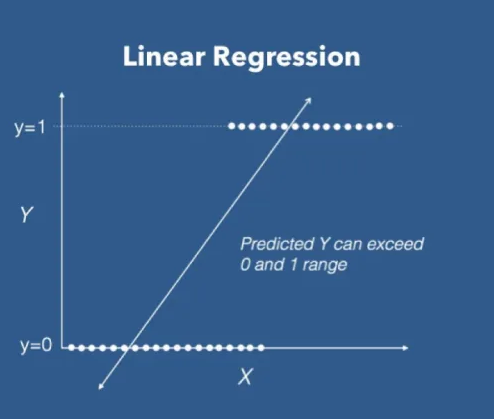

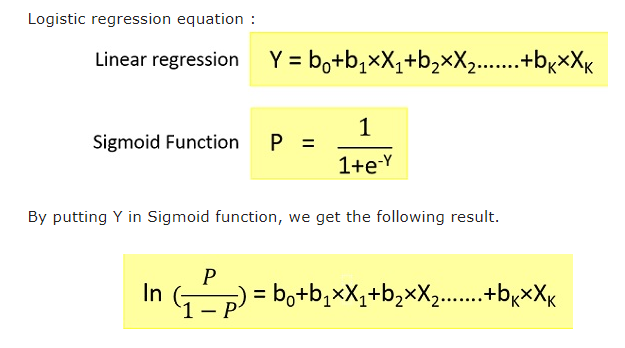

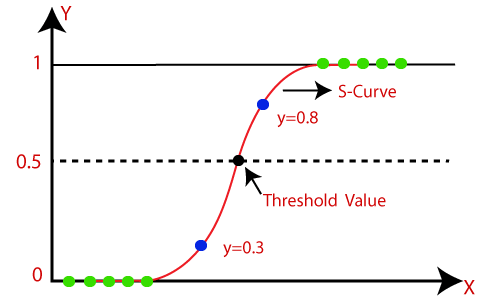

# **Data Set Information**:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


Data: https://www.kaggle.com/rouseguy/bankbalanced/data?select=bank.csv 

In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 65kB/s 
     |████████████████████████████████| 204kB 44.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=71eb4980431764e223e06f40906f23b9c490ef7d6aaf28d209f55842c1d2eb2c
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/BIG DATA PROCESSING/bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [ ]:
df.groupBy('deposit').count().collect()

[Row(deposit='no', count=5873), Row(deposit='yes', count=5289)]

In [ ]:
from pyspark.ml.feature import StringIndexer

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- maritalIndex: double (nullable = false)
 |-- educationIndex: double (nullable = false)
 |-- defaultIndex: double (nullable = false)
 |-- housingIndex: double (nullable = false)
 |-- loanIndex: double (nullable = false)
 |-- contactIndex: double (nullable = false)
 |-- poutcomeIndex: double (

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-0.5437750416296...|       1.0|[0.36730984916817...|
| 19|    student|  1.0|[0.45182253829449...|       0.0|[0.61107247127878...|
| 19|    student|  0.0|[-0.6086621494863...|       1.0|[0.35236444007684...|
| 19|    student|  1.0|[-0.2467746678704...|       1.0|[0.43861752182431...|
| 19|    student|  1.0|[-0.5124959008989...|       1.0|[0.37460861060403...|
| 19|    student|  1.0|[-1.2678304089887...|       1.0|[0.21962887650086...|
| 20|blue-collar|  1.0|[-0.3637896562331...|       1.0|[0.41004250757436...|
| 20|    student|  1.0|[-1.6726938346863...|       1.0|[0.15806535114548...|
| 20|    student|  1.0|[-2.1064997982678...|       1.0|[0.10846667850159...|
| 20|    student|  1.0|[-0.5173841681561...|       1.0|[0.37346410581779...|

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
print('Accuracy: ', evaluator.evaluate(predictions))

evaluator = MulticlassClassificationEvaluator(metricName='f1')
print('F1 score: ', evaluator.evaluate(predictions))

Accuracy:  0.7886301784094345
F1 score:  0.7884614909574474
